# Complex Queries and Basic Visualization

This notebook will cover how to make more complex queries, using both basic HTTP requests and using sharepa - the SHARE parsing and analysis library.

We'll also go over aggregations, or queries that will return summary statistics about the whole dataset. We'll use those aggregations to make some simple data visualizations using pandas and matplotlib.

## Setup

Here we'll define a helper function and specify the SHARE API url that we'll use for querying.

We'll also define another helper function to nicely print out our results.

In [2]:
# Json library parses JSON from strings or files. The library parses JSON into a Python dictionary or list. 
    # It can also convert Python dictionaries or lists into JSON strings. 
    # https://docs.python.org/2.7/library/json.html
import json

# Requests library allows you to send organic, grass-fed HTTP/1.1 requests, no need to manually add query strings 
    # to your URLs, or to form-encode your POST data. Docs: http://docs.python-requests.org/en/master/
import requests

# This takes the URL and puts it into a variable (so we only need to ever reference this variable, 
    # and so we don't have to repeat adding this URL when we want to work with the data)
SHARE_API = 'https://share.osf.io/api/v2/search/creativeworks/_search'

# A helper function that will use the requests library, pass along the correct headers, and make the query we want
def query_share(url, query):
    headers = {'Content-Type': 'application/json'}
    data = json.dumps(query)
    return requests.post(url, headers=headers, data=data, verify=False).json()

In [3]:
# A function that prints out the results in a numbered list
def print_numbered_results(results):
    print(
        'There are {} total results and {} results on this page'.format(
            results['hits']['total'],
            len(results['hits']['hits'])
        )
    )
    print('---------------')    
    for result in enumerate(results['hits']['hits']):
        print('{}. {}'.format(result[0] + 1, result[1]['_source']['title']))

## Complex Queries

### Pagination

One request to the SHARE API will return just 10 results by default. To get more results, you can use the "size" parameter in your request, or paginate through the results you get back.

In [4]:
# We are setting up a query for items in the SHARE dataset that have the keyword "frogs"
basic_query = {
    "query": {
        "query_string": {
            "query": "frogs"
        }
    }
}

#this puts the results of querying SHARE_API with what we outlined in basic_query (frogs)
query_results = query_share(SHARE_API, basic_query)

#print out the numbered list of the results
print_numbered_results(query_results)

There are 429 total results and 10 results on this page
---------------
1. Frogs mount speedy defence against pesticide threat
2. Behavioural ecology: Fungus makes tree frogs sing
3. Abundance of Green Tree Frogs and Insects in Artificial  Canopy Gaps in a Bottomland Hardwood Forest.
4. Representative two-color flow cytometry analysis of splenocytes from uninfected control frogs (A), and frogs infected for 6 days (B)
5. <p>Total annual biomass (g) of recaptured breeding wood frogs at 11 vernal pools in east-central Maine, USA.</p>
6. Boiling Frogs and Burning Out
7. Birds and Frogs: Selected Papers, 1990–2014
8. Zoology: Venomous frogs headbutt foe
9. Evolution: Wooing frogs are bat bait
10. Marsupial frogs: Gastrotheca & allied genera


/home/vicky/miniconda3/envs/share_tutorials/lib/python3.5/site-packages/requests/packages/urllib3/connectionpool.py:821: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.org/en/latest/security.html
  InsecureRequestWarning)


We can get more results either by changing the number of results returned, or by paginating through the results.

First, we'll return 20 results by specifying the size in our query.

In [5]:
# We are setting up a query for items in the SHARE dataset that have the keyword "frogs" but limiting the 
    # results to 20 items
basic_query = {
    "query": {
        "query_string": {
            "query": "frogs"
        }
    },
    "size": 20
}

# this puts the results of querying SHARE_API with what we outlined in basic_query (frogs)
query_results = query_share(SHARE_API, basic_query)

# print out the numbered list of the results
print_numbered_results(query_results)

There are 429 total results and 20 results on this page
---------------
1. Frogs mount speedy defence against pesticide threat
2. Behavioural ecology: Fungus makes tree frogs sing
3. Abundance of Green Tree Frogs and Insects in Artificial  Canopy Gaps in a Bottomland Hardwood Forest.
4. Representative two-color flow cytometry analysis of splenocytes from uninfected control frogs (A), and frogs infected for 6 days (B)
5. <p>Total annual biomass (g) of recaptured breeding wood frogs at 11 vernal pools in east-central Maine, USA.</p>
6. Boiling Frogs and Burning Out
7. Birds and Frogs: Selected Papers, 1990–2014
8. Zoology: Venomous frogs headbutt foe
9. Evolution: Wooing frogs are bat bait
10. Marsupial frogs: Gastrotheca & allied genera
11. Representative two-color flow cytometry analysis of splenocytes from uninfected control frogs (A), and frogs infected for 6 days (B)
12. Residues of Polybrominated Diphenyl Ethers in Frogs (<i>Rana limnocharis</i>) from a Contaminated Site, South Chi

/home/vicky/miniconda3/envs/share_tutorials/lib/python3.5/site-packages/requests/packages/urllib3/connectionpool.py:821: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.org/en/latest/security.html
  InsecureRequestWarning)


We can also paginate through results by specifying the place to start in all of the results.

In [6]:
# We are setting up a query for items in the SHARE dataset that have the keyword "frogs" 
basic_query = {
    "query": {
        "query_string": {
            "query": "frogs"
        }
    }
}

# creates a list of the first 10 results from the search query "frogs"
query_results = query_share(SHARE_API, basic_query)

# print the results of the search we made in a numbered list
print_numbered_results(query_results)

# make it visually pretty and readable for us humans
print('------------------------------------------')
print('*** Making another query for the next page ***')
print('*** These next titles will be different! ***')
print('------------------------------------------')

basic_query['from'] = 10  # Add the 'from' parameter to the query to pick up at the next page of results

# creates a list of the next 10 results 
query_results = query_share(SHARE_API, basic_query)

# print the results of the search we made in a numbered list
print_numbered_results(query_results)

There are 429 total results and 10 results on this page
---------------
1. Frogs mount speedy defence against pesticide threat
2. Behavioural ecology: Fungus makes tree frogs sing
3. Abundance of Green Tree Frogs and Insects in Artificial  Canopy Gaps in a Bottomland Hardwood Forest.
4. Representative two-color flow cytometry analysis of splenocytes from uninfected control frogs (A), and frogs infected for 6 days (B)
5. <p>Total annual biomass (g) of recaptured breeding wood frogs at 11 vernal pools in east-central Maine, USA.</p>
6. Boiling Frogs and Burning Out
7. Birds and Frogs: Selected Papers, 1990–2014
8. Zoology: Venomous frogs headbutt foe
9. Evolution: Wooing frogs are bat bait
10. Marsupial frogs: Gastrotheca & allied genera
------------------------------------------
*** Making another query for the next page ***
*** These next titles will be different! ***
------------------------------------------
There are 429 total results and 10 results on this page
---------------
1. R

/home/vicky/miniconda3/envs/share_tutorials/lib/python3.5/site-packages/requests/packages/urllib3/connectionpool.py:821: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.org/en/latest/security.html
  InsecureRequestWarning)
/home/vicky/miniconda3/envs/share_tutorials/lib/python3.5/site-packages/requests/packages/urllib3/connectionpool.py:821: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.org/en/latest/security.html
  InsecureRequestWarning)


### Pagination with sharepa

You can also use sharepa to paginate through all of the results in your query, and to access slices of your query at any time. The ShareSearch object returns a generator that you can use to access all results, using slices.

First, we'll redefine our helper function for nicer printing with data returned from sharepa.

In [11]:
# this is a function that helps us print the lists with pagination between results (10, next 10, etc.)
def print_numbered_sharepa_results(search_obj):
    results = search_obj.execute()
    print(
        'There are {} total results and {} results on this page'.format(
            search_obj.count(),
            len(results.hits)
        )
    )
    print('---------------')    
    for result in enumerate(results.hits):
        print('{}. {}'.format(result[0] + 1, result[1]['title']))

In [12]:
# Sharepa is a python client for  browsing and analyzing SHARE data specifically using elasticsearch querying.
    # We can use this to aggregate, graph, and analyze the data. 
    # Helpful Links:
        # https://github.com/CenterForOpenScience/sharepa
        # https://pypi.python.org/pypi/sharepa
    # here, we import the specific function from Sharepa called ShareSearch and pretty_print
from sharepa import ShareSearch
from sharepa.helpers import pretty_print

# we are creating a new local search!
frogs_search = ShareSearch()

# this sets up what we will actually search for -- keyword "frogs"
frogs_search = frogs_search.query(
    'query_string',
    query='frogs'
)

In [9]:
# print the results of the search we made for "frogs" keyword in a numbered list
print_numbered_sharepa_results(frogs_search)

There are 1303 total results and 10 results on this page
---------------
1. Herpetology Collection - Royal Ontario Museum
2. Herpetology Collection - Royal Ontario Museum
3. On a collection of reptiles and frogs chiefly from Singapore.
4. Effects of nonlethal predation and competition on life-history characteristics and behavior of larval Oregon spotted frog (Rana pretiosa) and larval red-legged frog (Rana aurora)
5. Differences in foraging habits during the day and night time in the green frog, Rana clamitans.
6. Calling activity of Eleutherodactylus frogs of Puerto Rico and habitat distribution of E. richmondi
7. Evaluating group housing strategies for the ex-situ conservation of harlequin frogs (Atelopus spp.) using behavioral and physiological indicators
8. Calling activity of Eleutherodactylus frogs of Puerto Rico and habitat distribution of E. richmondi
9. <p>Total annual biomass (g) of recaptured breeding wood frogs at 11 vernal pools in east-central Maine, USA.</p>
10. Correcti

In [10]:
# print the 10th - 20th results of the search we made for "frogs" keyword in a numbered list
print_numbered_sharepa_results(frogs_search[10:20])

There are 1303 total results and 10 results on this page
---------------
1. Fatigue and work capacity of muscles from frogs treated with male sex hormone
2. The frog book; North American toads and frogs, with a study of the habits and life histories of those of the northeastern states. 
3. Condition-dependent reproductive effort in frogs infected by a widespread pathogen
4. Physiologische studien über die Hemmungsmechanismen für die reflexthätigkeit des Rückenmarks im gehirne des Frosches / 
5. Overwintering of Columbia spotted frogs in northeastern Oregon
6. Mycobacterium liflandii Outbreak in a Research Colony of Xenopus (Silurana) tropicalis Frogs
7. <i>Frankixalus</i>, a New Rhacophorid Genus of Tree Hole Breeding Frogs with Oophagous Tadpoles
8. Residues of Polybrominated Diphenyl Ethers in Frogs (<i>Rana limnocharis</i>) from a Contaminated Site, South China: Tissue Distribution, Biomagnification, and Maternal Transfer
9. Cryoprotectants and Extreme Freeze Tolerance in a Subarcti

### Aggregations

While searching for individual results is useful, sharepa also lets you make aggregation queries that give you results across the entirety of the SHARE dataset at once. This is useful if you're curious about the completeness of data sets.

For example, we can find the number of documents per source that are missing tags.

In [ ]:
# this aggregates the number of documents that have no tags, per source, using query boolean (not tags) while also 
    # grabbing all sources in the aggregations: sources below
missing_tags_aggregation = {
    "query": {
        "bool": {
            "must_not": {
                "exists": {
                    "field": "tags"
                  }
            }
        }
    },
    "aggregations": {
        "sources": {
            "terms": {
                "field": "sources", # A field where the SHARE source is stored                
                "min_doc_count": 0, 
                "size": 0  # Will return all sources, regardless if there are results
            }
        }
    }
}

In [ ]:
# puts all the items without tags into a list
results_without_tags = query_share(SHARE_API, missing_tags_aggregation)

# counts the number of items without tags
missing_tags_counts = results_without_tags['aggregations']['sources']['buckets']

# this prints out the number of documents with missing tags, separated by sources
for source in missing_tags_counts:
    print('{} has {} documents without tags'.format(source['key'], source['doc_count'], ))

This information isn't terribly useful if we don't also know how many documents are in each source.

Let's get that information as well, along stats for what percentage of documents from each source are missing titles. 

We'll do this with an elasticsearch "sigificant terms" aggregation. We're only interested in results that have 1 document or more, meaning all documents from the other sources have titles.

In [ ]:
# this does the same as above, but adds the percentage of documents missing tags from the total number of documents
    # per source
no_tags_query = {
    "query": {
        "bool": {
            "must_not": {
                "exists": {
                    "field": "tags"
                  }
            }
        }
    },
    "aggs": {
        "sources":{
            "significant_terms":{
                "field": "sources", # A field where the SHARE source is stored                
                "min_doc_count": 0, 
                "size": 0,  # Will return all sources, regardless if there are results
                "percentage": {} # This will make the "score" parameter a percentage
            }
        }
    }
}

In [ ]:
# creates a list of the documents with no tags
docs_with_no_tags_results = query_share(SHARE_API, no_tags_query)

#creates a dictionary that shows the results of the search along with the aggregations we outlined above
docs_with_no_tags = docs_with_no_tags_results['aggregations']['sources']['buckets']

In [ ]:
# this prints out the number of documents with missing tags, separated by sources, with the percentage that makes up
    # the total number of documents for each source
for source in docs_with_no_tags:
    print(
        '{}% (or {}/{}) of documents from {} have no tags'.format(
            format(source['score']*100, '.2f'),
            source['doc_count'],
            source['bg_count'],
            source['key']
        )
    )

#### Aggregations with sharepa

You can also use sharepa to do aggregations.

Let's make a sharepa search object that will give us the number of documents per sourcethat don't have language specified.

In [ ]:
# yay! creating another new search! 
no_language_search = ShareSearch()

# this sets up our search query: all documents with no language field
no_language_search = no_language_search.query(
    'bool',
    must_not={"exists": {"field": "language"}}
)

no_language_search.aggs.bucket(
    'sources',  # Every aggregation needs a name
    'significant_terms',  # There are many kinds of aggregations
    field='sources',  # We store the source of a document in its type, so this will aggregate by source
    min_doc_count=1,
    percentage={},
    size=0
)

We can see which query is actually going to be sent to elasticsearch by printing out the query. This is very similar to the queries we were defining by hand up above.

In [ ]:
# print (prettily!) the items grabbed the search that have no language field
pretty_print(no_language_search.to_dict())

In [ ]:
# here we grab the results of items that have no language field + their sources and significant terms
aggregated_results = no_language_search.execute()

# this prints out the percentage of items that don't have a language field
for source in aggregated_results.aggregations['sources']['buckets']:
    print(
        '{}% of documents from {} do not have language'.format(
            format(source['score']*100, '.2f'),
            source['key'] 
        )
    )

### Top tags 

Let's do an elasticsearch query to find out what the most used tags are used in the dataset across all sources.

In [14]:
# creating another new search!
top_tag_search = ShareSearch()

# this sets up our search query with the aggregations
top_tag_search.aggs.bucket(
    'tagsTermFilter',  # Every aggregation needs a name
    'terms',  # There are many kinds of aggregations
    field='tags',  # We store the source of a document in its type, so this will aggregate by source
    min_doc_count=1,
    exclude= "of|and|or",
    size=10
)

# pretty_print(top_tag_search.to_dict())

# this executes the search as we've outlined it above
top_tag_results_executed = top_tag_search.execute()

# this places the results of the search into this dictionary
top_tag_results = top_tag_results_executed.aggregations.tagsTermFilter.to_dict()['buckets']

# this prints out our search results (prettily)
pretty_print(top_tag_results)

[
    {
        "key": "journal",
        "doc_count": 143877
    },
    {
        "key": "science",
        "doc_count": 95645
    },
    {
        "key": "all",
        "doc_count": 91333
    },
    {
        "key": "j",
        "doc_count": 82511
    },
    {
        "key": "medicine",
        "doc_count": 68313
    },
    {
        "key": "research",
        "doc_count": 53404
    },
    {
        "key": "engineering",
        "doc_count": 49775
    },
    {
        "key": "the",
        "doc_count": 47455
    },
    {
        "key": "chemistry",
        "doc_count": 45017
    },
    {
        "key": "health",
        "doc_count": 44403
    }
]


## Basic Plotting

Sharepa has some basic functions to get you started making plots using matplotlib and pandas.

### Creating a dataframe from sharepa data

Raw sharepa data is in the same format as elasticsearch results, represented as a nested structure. To convert the data into a format that pandas can recognize, we have to convert it into a dataframe.

Let's take our top tags aggregation, make it into a pandas data frame, and plot a bar graph. Then, we'll plot the results.

In [15]:
# Pandas is a python library that is used for data manipulation and analysis -- good for numbers + time series.
    # Pandas gives us some extra data structures (arrays are data structures, for example) which is nice
    # We are calling Pandas pd by using the "as" -- locally, we know Pandas as pd
    # Helpful Links:
        # https://en.wikipedia.org/wiki/Pandas_(software)
        # http://pandas.pydata.org/ 
import pandas as pd

# this transforms our results from the cell above into a dataframe
top_tags_dataframe = pd.DataFrame(top_tag_results)

#this prints out our dataframe -- looks like a nice table!
top_tags_dataframe

,doc_count,key
0,143877,journal
1,95645,science
2,91333,all
3,82511,j
4,68313,medicine
5,53404,research
6,49775,engineering
7,47455,the
8,45017,chemistry
9,44403,health


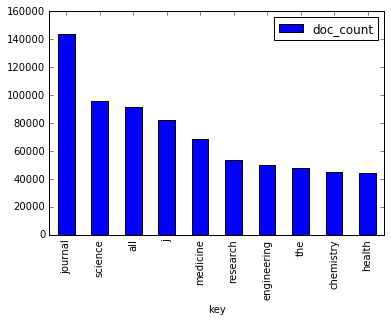

In [17]:
# Matplot lib is a a python 2D plotting library which produces publication quality figures in a variety of hardcopy
    # formats and interactive environments across platforms. 
    # Read more about Matplotlib here: http://matplotlib.org/
from matplotlib import pyplot

# this is used specifically with iPython notebooks to display the matplotlib chart or graph in the notebook
%matplotlib inline

#this takes our results dictionary from the cell above and plots them into a bar chart
top_tags_dataframe.plot(kind='bar', x='key', y='doc_count')

# this prints out the bar chart we just made!
pyplot.show()

### Complex Queries and Dataframes

Let's plot the number of document that each source has. We'll limit it to the top 30 sources to make sure that the graph is readable. Here we'll use the sharepa helper function bucket_to_dataframe()

In [18]:
# from the SHAREPA library, we import this function to transform a bucket into a dataframe so we can plot it!
from sharepa import bucket_to_dataframe

# creating a new search! 
all_results = ShareSearch()

# creating our search query!
all_results = all_results.query(
    'query_string', # Type of query, will accept a lucene query string
    query='*', # This lucene query string will find all documents that don't have tags
    analyze_wildcard=True  # This will make elasticsearch pay attention to the asterisk (which matches anything)
)

# Lucene supports fielded data. When performing a search you can either specify a field, or use the default field. 
all_results.aggs.bucket(
    'sources',  # Every aggregation needs a name
    'terms',  # There are many kinds of aggregations, terms is a pretty useful one though
    field='sources',  # We store the source of a document in its type, so this will aggregate by source
    size=0,  # These are just to make sure we get numbers for all the sources, to make it easier to combine graphs
    min_doc_count=0
)

# this executes our search!
all_results = all_results.execute()

# this uses that function we imported above to transform our aggregated search into a dataframe so we can plot it!
all_results_frame = bucket_to_dataframe('# documents by source', all_results.aggregations.sources.buckets)

# this sorts the dataframe by the number of documents by source (descending order)
all_results_frame_sorted = all_results_frame.sort(ascending=False,  columns='# documents by source')

# this creates a bar chart that displays the first 30 results 
all_results_frame_sorted[:30].plot(kind='bar')

/home/vicky/miniconda3/envs/share_tutorials/lib/python3.5/site-packages/ipykernel/__main__.py:30: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


TypeError: Empty 'DataFrame': no numeric data to plot

We can choose different types of plots to generate. Here, we'll make a pie chart of the data sources with the top 10 most results.

In [ ]:
# Creating a pie graph using the first 10 items in the data frame with no legend
all_results_frame_sorted[:10].plot(kind='pie', y="# documents by source", legend=False)